In [ ]:
%%capture
# !pip install opendatasets
# import opendatasets as od
# od.download("https://www.kaggle.com/datasets/mahmoudima/mma-facial-expression","/data")

In [1]:
# !pip install opencv-python
# !pip install imgaug
# !pip install scikit-learn
# !pip install mtcnn

In [1]:
#make a function that calculates the files in a directory and subdirectories
import os
def count_files(path):
    count = 0
    for root, dirs, files in os.walk(path):
        count += len(files)
    return count

In [2]:
print(count_files("data/test"), count_files("data/train"), count_files("data/valid"))

17356 92968 17356


In [3]:
def load_dataset(folder_path):
    images = []
    labels = []
    emotions = []
    
    for emotion in os.listdir(folder_path):
        emotion_folder = os.path.join(folder_path, emotion)
        if os.path.isdir(emotion_folder):
            emotions.append(emotion)  # Store the emotion in the order encountered
            for image_file in os.listdir(emotion_folder):
                image_path = os.path.join(emotion_folder, image_file)
                image = cv2.imread(image_path)
                if image is not None:
                    images.append(image)
                    labels.append(emotion)
    
    return images, labels, emotions

In [4]:
import os
import cv2

# Example usage:
train_folder = "data/train"
validation_folder = "data/valid"
test_folder = "data/test"

train_images, train_labels, train_emotions = load_dataset(train_folder)
%store train_images
%store train_labels
%store train_emotions

Stored 'train_images' (list)
Stored 'train_labels' (list)
Stored 'train_emotions' (list)


In [5]:
validation_images, validation_labels, validation_emotions = load_dataset(validation_folder)
%store validation_images
%store validation_labels
%store validation_emotions

Stored 'validation_images' (list)
Stored 'validation_labels' (list)
Stored 'validation_emotions' (list)


In [6]:
test_images, test_labels, test_emotions = load_dataset(test_folder)
%store test_images
%store test_labels         #save for later
%store test_emotions

Stored 'test_images' (list)
Stored 'test_labels' (list)
Stored 'test_emotions' (list)


In [7]:
print("Train emotions order:", train_emotions)
print("Validation emotions order:", validation_emotions)
print("Test emotions order:", test_emotions)

Train emotions order: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Validation emotions order: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Test emotions order: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [8]:
len(train_images), len(validation_images), len(test_images)

(92968, 17356, 17356)

In [11]:
import imgaug.augmenters as iaa

def augment_dataset(images, labels):
    augmented_images = []
    augmented_labels = []

    seq = iaa.Sequential([
        iaa.Fliplr(0.5),  # flip horizontally with a 50% chance
        iaa.Affine(rotate=(-10, 10)),  # rotate images by -10 to 10 degrees
        iaa.GaussianBlur(sigma=(0, 1.0)),  # apply Gaussian blur with sigma between 0 and 1.0
        iaa.AdditiveGaussianNoise(scale=(0, 0.05 * 255)),  # add Gaussian noise
        iaa.Resize({"height": 64, "width": 64})  # resize images to 64x64 pixels
    ], random_order=True)

    for image, label in zip(images, labels):
        augmented_images.extend(seq(images=[image] * 3))  # Augment each image 3 times for increased diversity
        augmented_labels.extend([label] * 3)

    return augmented_images, augmented_labels

# Example usage:
augmented_train_images, augmented_train_labels = augment_dataset(train_images, train_labels)
augmented_test_images, augmented_test_labels = augment_dataset(test_images, test_labels)
augmented_validation_images, augmented_validation_labels = augment_dataset(validation_images, validation_labels)    

In [ ]:

import cv2
import numpy as np
from sklearn.model_selection import train_test_split

def preprocess_images(images):
    preprocessed_images = []
    for image in images:
        # Convert image to grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        # Resize image to a consistent size (e.g., 64x64)
        resized = cv2.resize(gray, (64, 64))
        # Normalize pixel values to [0, 1]
        normalized = resized / 255.0
        preprocessed_images.append(normalized)
    
    return np.array(preprocessed_images)

# Preprocess augmented training images
preprocessed_train_images = preprocess_images(augmented_train_images)
# Preprocess validation and testing images
preprocessed_validation_images = preprocess_images(augmented_validation_images)
preprocessed_test_images = preprocess_images(augmented_test_images)


# Split augmented training data into training and validation sets
"""from sklearn.model_selection import train_test_split
preprocessed_train_images = train_images
preprocessed_validation_images = validation_images
preprocessed_test_images = test_images
augmented_train_labels = train_labels"""


preprocessed_train_images, preprocessed_validation_images, train_labels, validation_labels = train_test_split(
    preprocessed_train_images, augmented_train_labels, test_size=0.4, random_state=42
)
%store preprocessed_train_images            #save for later
%store preprocessed_validation_images       #save for later
%store train_labels                         #save for later
%store validation_labels                    #save for later

In [11]:
import tensorflow as tf
from tensorflow.python.client import device_lib

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
device_lib.list_local_devices()

Num GPUs Available:  1


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 12790480688186282634
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 1721342363
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 10384458940637741501
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3050 Ti Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
 xla_global_id: 416903419]

Training

In [16]:
tf.keras.backend.clear_session()

In [17]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np

# Define the CNN model architecture
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(7, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Reshape preprocessed images for CNN input
train_images_reshaped = np.expand_dims(preprocessed_train_images, axis=-1)
#validation_images_reshaped = np.expand_dims(preprocessed_validation_images, axis=-1)

# Verify the shape and data type
print(train_images_reshaped.shape)  # Check the shape
print(train_images_reshaped.dtype)  # Check the data type

# Confirm the number of channels
# If images are RGB, adjust the input shape accordingly

# Define a mapping of emotions to numerical labels
emotion_mapping = {
    'angry': 0,
    'disgust': 1,
    'fear': 2,
    'happy': 3,
    'neutral': 4,
    'sad': 5,
    'surprise': 6
}

# Convert emotion labels to numerical labels
train_labels_encoded = np.array([emotion_mapping[label] for label in train_labels])
#validation_labels_encoded = np.array([emotion_mapping[label] for label in validation_labels])

# Train the model
history = model.fit(train_images_reshaped, train_labels_encoded)#, epochs=1),# validation_data=(validation_images_reshaped, validation_labels_encoded))


(167342, 64, 64, 1)
float64


InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [15]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt

# Define the CNN model architecture
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(7, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Reshape preprocessed images for CNN input
train_images_reshaped = np.expand_dims(preprocessed_train_images, axis=-1)
#validation_images_reshaped = np.expand_dims(preprocessed_validation_images, axis=-1)

# Verify the shape and data type
print(train_images_reshaped.shape)  # Check the shape
print(train_images_reshaped.dtype)  # Check the data type

# Confirm the number of channels
# If images are RGB, adjust the input shape accordingly

# Define a mapping of emotions to numerical labels
emotion_mapping = {
    'angry': 0,
    'disgust': 1,
    'fear': 2,
    'happy': 3,
    'neutral': 4,
    'sad': 5,
    'surprise': 6
}

# Convert emotion labels to numerical labels
train_labels_encoded = np.array([emotion_mapping[label] for label in train_labels])
#validation_labels_encoded = np.array([emotion_mapping[label] for label in validation_labels])
print(len(train_labels_encoded))
# Set the batch size
batch_size = 640

# Train the model with batch processing and keep track of metrics
history = model.fit(train_images_reshaped, train_labels_encoded, batch_size=batch_size, epochs=20) #, validation_data=(validation_images_reshaped, validation_labels_encoded))


# Plot the accuracy and loss curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


(167342, 64, 64, 1)
float64
167342


InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

other solutions

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""

import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt

# Rest of your code ...

# Define the CNN model architecture
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(7, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
# Reshape preprocessed images for CNN input
train_images_reshaped = np.expand_dims(preprocessed_train_images, axis=-1)
validation_images_reshaped = np.expand_dims(preprocessed_validation_images, axis=-1)

# Verify the shape and data type
print(train_images_reshaped.shape)  # Check the shape
print(train_images_reshaped.dtype)  # Check the data type

# Confirm the number of channels
# If images are RGB, adjust the input shape accordingly

# Define a mapping of emotions to numerical labels
emotion_mapping = {
    'angry': 0,
    'disgust': 1,
    'fear': 2,
    'happy': 3,
    'neutral': 4,
    'sad': 5,
    'surprise': 6
}

# Convert emotion labels to numerical labels
train_labels_encoded = np.array([emotion_mapping[label] for label in train_labels])
validation_labels_encoded = np.array([emotion_mapping[label] for label in validation_labels])

# Set the batch size
batch_size = 64

# Train the model with batch processing and keep track of metrics
history = model.fit(train_images_reshaped, train_labels_encoded, batch_size=batch_size, epochs=20)
#, validation_data=(validation_images_reshaped, validation_labels_encoded))


# Plot the accuracy and loss curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Save the trained model
model.save('emotion_detection_model.h5')

<h4>To perform test on a single image</h4>

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import cv2
import numpy as np

# Load the saved model
model = load_model('emotion_detection_model.h5')

# Load and preprocess the new image
image = cv2.imread('fear.jpg', cv2.IMREAD_GRAYSCALE)
image = cv2.resize(image, (64, 64))
image = image.astype('float32') / 255.0
image = np.expand_dims(image, axis=0)
image = np.expand_dims(image, axis=-1)

#show image
plt.imshow(image[0,:,:,0], cmap='gray')
plt.show()

# Make predictions
predictions = model.predict(image)
predicted_class = np.argmax(predictions[0])

# Print the predicted class and probability distribution
# angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'
emotion_mapping = {
    0: 'angry',
    1: 'disgust',
     2: 'fear',
     3: 'happy',
     4: 'neutral',
     5: 'sad',
     6: 'surprise'
}

predicted_emotion = emotion_mapping[predicted_class]
print('Predicted Emotion:', predicted_emotion)
print('Probability Distribution:', predictions[0])


<h4>To perform test on multiple images stored in a folder </h4>

1/1 [==============================] - 5s 5s/step


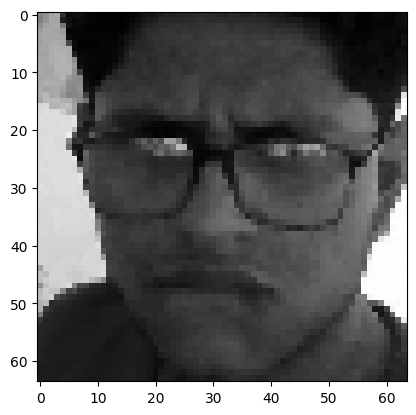

File: testAngry.jpg
Predicted Emotion: disgust
Probability Distribution: [1.8112902e-01 6.9795084e-01 8.1173217e-05 1.2004823e-01 7.9072983e-04
 6.2047102e-19 2.4849275e-18]
------------------------
No face detected in testDisgust.jpg
1/1 [==============================] - 0s 19ms/step


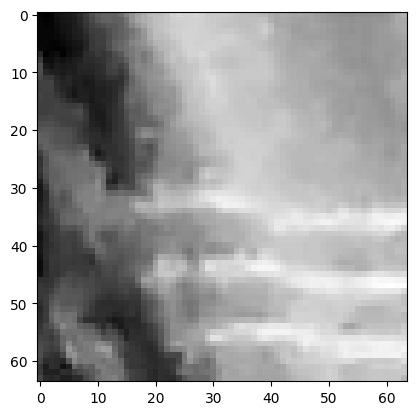

File: testHappy.jpg
Predicted Emotion: happy
Probability Distribution: [1.1680854e-02 1.4491909e-06 1.9403574e-07 9.3733561e-01 5.0981849e-02
 4.3359247e-11 5.0234190e-09]
------------------------
No face detected in testNeutrak.jpg
1/1 [==============================] - 0s 17ms/step


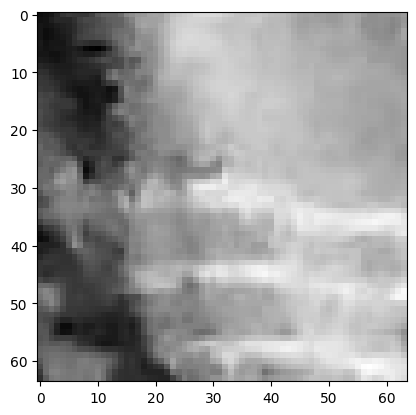

File: testNeutral.jpg
Predicted Emotion: happy
Probability Distribution: [9.6241131e-02 5.7935540e-06 5.8404606e-07 7.8713441e-01 1.1661809e-01
 1.4725124e-10 1.0812191e-08]
------------------------
1/1 [==============================] - 0s 16ms/step


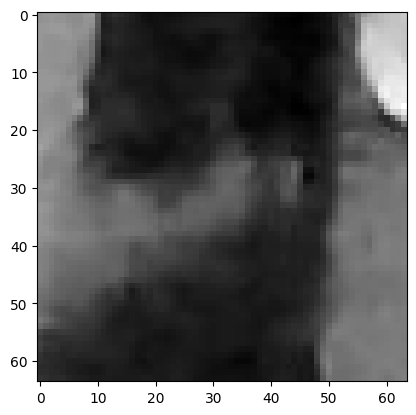

File: testNeutral1.jpg
Predicted Emotion: neutral
Probability Distribution: [8.1665164e-09 7.5342233e-04 7.1568186e-03 2.6444665e-01 7.2764307e-01
 2.5388865e-11 3.4614409e-11]
------------------------
1/1 [==============================] - 0s 18ms/step


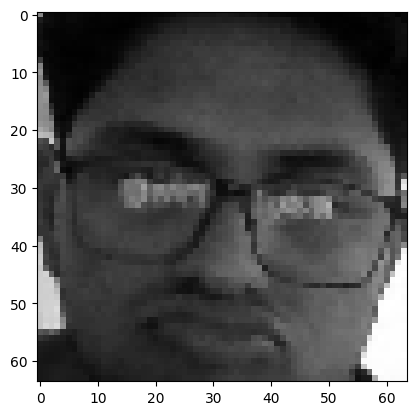

File: testSad.jpg
Predicted Emotion: neutral
Probability Distribution: [1.8274855e-13 1.0420808e-05 4.4328336e-11 1.3691357e-03 9.9862039e-01
 4.8177176e-15 5.2927394e-16]
------------------------


In [10]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import cv2
import numpy as np
import os
from faces import extract_face
import matplotlib.pyplot as plt

# Load the saved model
model = load_model('emotion_detection_model.h5')

# Define the emotion mapping
emotion_mapping = {
    0: 'angry',
    1: 'disgust',
    2: 'fear',
    3: 'happy',
    4: 'neutral',
    5: 'sad',
    6: 'surprise'
}

# Folder path containing the test images
test_folder = 'selfTest'

# Iterate over each file in the test folder
for filename in os.listdir(test_folder):
    # Load and preprocess the image
    image_path = os.path.join(test_folder, filename)
    face = extract_face(image_path)

    if face is not None:
        # Preprocess the extracted face
        face = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
        face = cv2.resize(face, (64, 64))
        face = face.astype('float32') / 255.0
        face = np.expand_dims(face, axis=0)
        face = np.expand_dims(face, axis=-1)

        # Make predictions
        predictions = model.predict(face)
        predicted_class = np.argmax(predictions[0])
        predicted_emotion = emotion_mapping[predicted_class]

        # Show the image
        plt.imshow(face[0, :, :, 0], cmap='gray')
        plt.show()

        # Print the predicted emotion and probability distribution
        print('File:', filename)
        print('Predicted Emotion:', predicted_emotion)
        print('Probability Distribution:', predictions[0])
        print('------------------------')
    else:
        print('No face detected in', filename)


<h4>Test with camera</h4>

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import cv2
import numpy as np

# Load the saved model
model = load_model('emotion_detection_model.h5')

# Define the emotion mapping
emotion_mapping = {
    0: 'angry',
    1: 'disgust',
    2: 'fear',
    3: 'happy',
    4: 'neutral',
    5: 'sad',
    6: 'surprise'
}

# Function to extract human face from image using HOG algorithm
def extract_face(image):
    # Load the pre-trained HOG face detector
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Detect faces in the image
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    # Extract the first detected face (assuming only one face is present)
    if len(faces) > 0:
        (x, y, w, h) = faces[0]
        face = image[y:y+h, x:x+w]
        return (face, (x, y, w, h))

    return (None, None)

# Open the video capture
cap = cv2.VideoCapture(0)

while True:
    # Read the frame from the video capture
    ret, frame = cap.read()

    # Extract the face from the frame
    face, face_coords = extract_face(frame)

    if face is not None:
        # Preprocess the extracted face
        face = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
        face = cv2.resize(face, (64, 64))
        face = face.astype('float32') / 255.0
        face = np.expand_dims(face, axis=0)
        face = np.expand_dims(face, axis=-1)

        # Make predictions
        predictions = model.predict(face)
        predicted_class = np.argmax(predictions[0])
        predicted_emotion = emotion_mapping[predicted_class]

        # Mark the predicted emotion on the frame
        (x, y, w, h) = face_coords
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
        cv2.putText(frame, predicted_emotion, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

    # Display the frame
    cv2.imshow('Emotion Detection', frame)

    # Break the loop if 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the video capture
cap.release()
cv2.destroyAllWindows()


: 

<h1>TODO</h1>
<h4>Multiple faces in the same image</h4>
<h4>Combine multiple images into one</h4>
<h4>Try vj for face recognition</h4>
blanks grid with random images, and spaces, random grid